In [25]:
import os
from pathlib import Path

while Path.cwd().name.lower() != "aiml25-exam" and "aiml25-exam" in str(Path.cwd()).lower():
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/isimisi/Documents/GitHub/isimisi/AIML25-Exam


In [26]:
from src.yolo.yolo import Yolo
from ultralytics import YOLO
from src.utils.path import from_root
from src.llm_caller import LLMCaller
from src.llm_detector import Detector
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

In [27]:
model = YOLO(from_root("models/yolo-trained.pt"))

yolo = Yolo(model)

In [28]:
from decouple import config

WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"
OPENAI_KEY = config("OPENAI_API_KEY")
# OPENAI_API_URL = "https://api.openai.com/v1"
# OPENAI_PROJECT = "proj_6SmPVkyXa0GChFv7TmDjB9B5"

model = LLMCaller(
    api_key=OPENAI_KEY,          
    model_id="gpt-4o",     
    params={
        "temperature": 0.7,
        "max_tokens": 150
    })

In [29]:
detector = Detector(model, yolo)



In [30]:
detector.initiate_image(str(from_root("datasets/test/images/4.png")), should_crop=True)


image 1/1 /Users/isimisi/Documents/GitHub/isimisi/AIML25-Exam/datasets/test/images/4.png: 384x640 7 sub-flows, 685.2ms
Speed: 1.2ms preprocess, 685.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
totale images: 7


In [31]:
detector.detect_nodes()

In [32]:
detector.detect_edges()

In [33]:
graph = detector.get_graph()

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/aiml25-exam/lib/python3.12/site-packages/matplotlib/pyplot.py'>

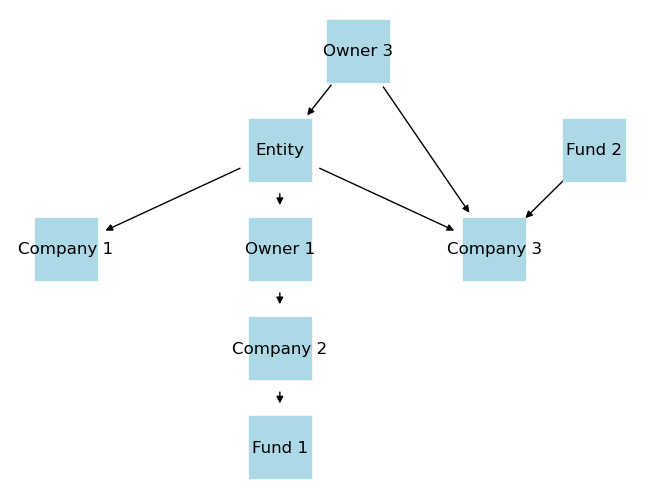

In [34]:
di_graph = graph.create_digraph()
graph.plot_digraph(di_graph)

In [35]:
from src.edge_validator import EdgeValidator

validator = EdgeValidator.from_json_file(str(from_root("datasets/test/json/4.json")), graph.edges)

In [36]:
validator.validate()

{'true_positives': ['owner1-company2',
  'owner3-company3',
  'owner3-entity',
  'fund2-company3',
  'entity-company1'],
 'false_positives': ['company2-fund1', 'entity-owner1', 'entity-company3'],
 'precision': 0.625,
 'recall': 0.7142857142857143,
 'f1_score': 0.6666666666666666}